# Diabetes ML



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path('../data/dataset.csv')
assert DATA_PATH.exists(), f"Missing dataset at {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


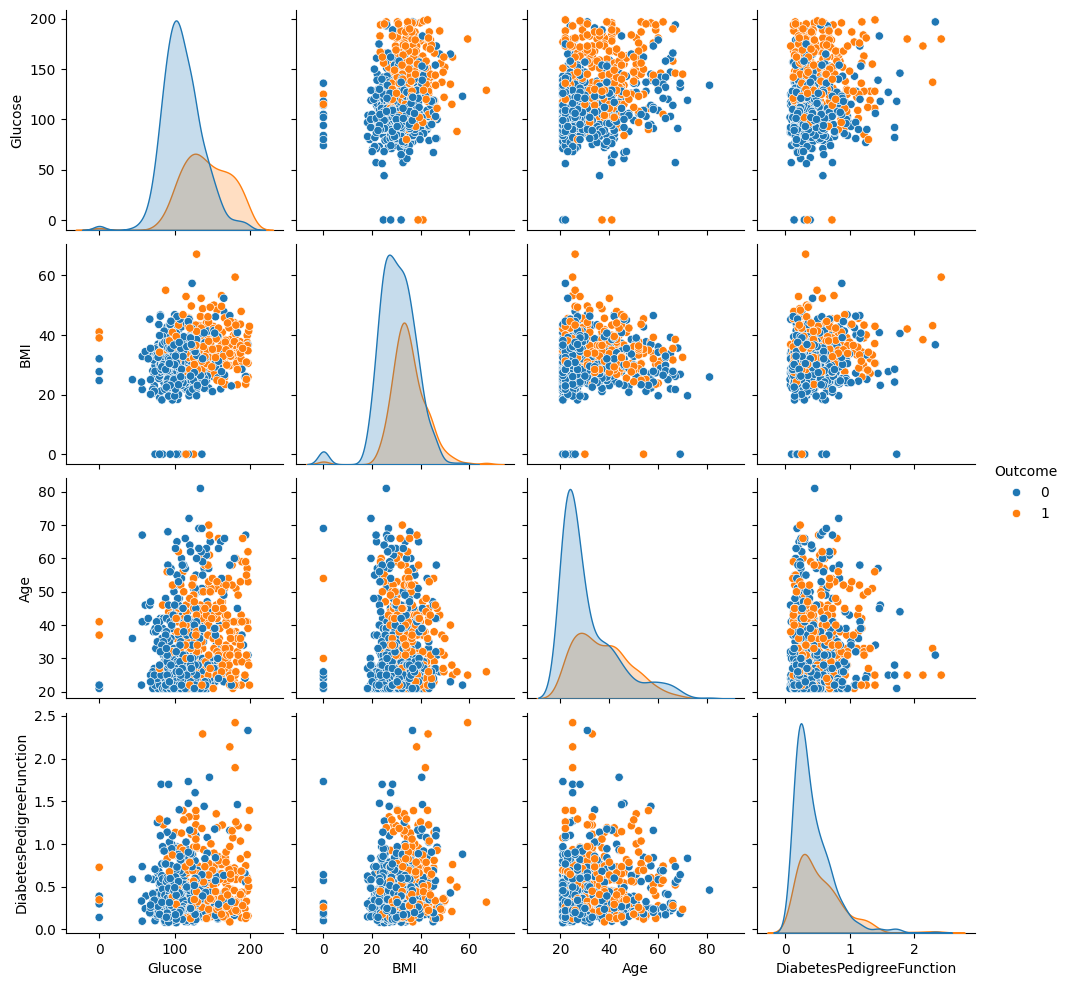

In [3]:
sns.pairplot(df[['Glucose','BMI','Age','DiabetesPedigreeFunction','Outcome']], hue='Outcome');
plt.show()


In [4]:
# Shared setup: data, preprocessing, CV, and train/test split
from pathlib import Path
import sys
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split

root = Path('..').resolve()
if str(root) not in sys.path:
    sys.path.append(str(root))

data_path = root / 'data' / 'dataset.csv'

# Load data
df = pd.read_csv(data_path)
# Ensure measurement_type exists (fasting/post_meal). Default to 'fasting' if missing.
if 'measurement_type' not in df.columns:
    df['measurement_type'] = 'fasting'

feature_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age",
]
X = df[feature_names + ["measurement_type"]]
y = df["Outcome"].astype(int)

# Treat zeros as missing for selected columns only
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
other_numeric_cols = [c for c in feature_names if c not in zero_as_missing]
categorical_cols = ["measurement_type"]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "zero_missing",
            Pipeline([
                ("imputer", SimpleImputer(missing_values=0, strategy="median")),
                ("scaler", StandardScaler()),
            ]),
            zero_as_missing,
        ),
        (
            "other_numeric",
            Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]),
            other_numeric_cols,
        ),
        (
            "categorical",
            Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]),
            categorical_cols,
        ),
    ],
    remainder="drop",
)

# Cross-validation setup and holdout split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Prepared shared dataset, preprocessor, CV splitter, and train/test split.")


Prepared shared dataset, preprocessor, CV splitter, and train/test split.


In [5]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Handle class imbalance with class_weight
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced", random_state=42)
log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", log_reg),
])

# Cross-validated ROC AUC
log_reg_cv_scores = cross_val_score(
    log_reg_pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1
)
print(
    f"log_reg: ROC AUC CV mean={log_reg_cv_scores.mean():.4f} +/- {log_reg_cv_scores.std():.4f}"
)

# Fit on train and evaluate on holdout
log_reg_pipeline.fit(X_tr, y_tr)
log_reg_prob = log_reg_pipeline.predict_proba(X_te)[:, 1]
log_reg_pred = (log_reg_prob >= 0.5).astype(int)
log_reg_holdout_auc = roc_auc_score(y_te, log_reg_prob)
log_reg_cm = confusion_matrix(y_te, log_reg_pred)
log_reg_report = classification_report(y_te, log_reg_pred, output_dict=True)

print(f"log_reg holdout ROC AUC={log_reg_holdout_auc:.4f}")


log_reg: ROC AUC CV mean=0.8362 +/- 0.0203
log_reg holdout ROC AUC=0.8126


In [6]:
# Model 2: Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Handle class imbalance with class_weight
rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf),
])

# Cross-validated ROC AUC
rf_cv_scores = cross_val_score(
    rf_pipeline, X, y, cv=cv, scoring="roc_auc", n_jobs=-1
)
print(
    f"random_forest: ROC AUC CV mean={rf_cv_scores.mean():.4f} +/- {rf_cv_scores.std():.4f}"
)

# Fit on train and evaluate on holdout
rf_pipeline.fit(X_tr, y_tr)
rf_prob = rf_pipeline.predict_proba(X_te)[:, 1]
rf_pred = (rf_prob >= 0.5).astype(int)
rf_holdout_auc = roc_auc_score(y_te, rf_prob)
rf_cm = confusion_matrix(y_te, rf_pred)
rf_report = classification_report(y_te, rf_pred, output_dict=True)

print(f"random_forest holdout ROC AUC={rf_holdout_auc:.4f}")


random_forest: ROC AUC CV mean=0.8300 +/- 0.0204
random_forest holdout ROC AUC=0.8184


In [ ]:
# Compare  models (Logistic Regression vs Random Forest) and persist best
from pathlib import Path
import json
import joblib

from sklearn.metrics import roc_auc_score, brier_score_loss

root = Path('..').resolve()
model_path = root / 'model.pkl'

# Evaluate two models on holdout
candidates = [("log_reg", log_reg_pipeline), ("random_forest", rf_pipeline)]
results = []
for name, pipe in candidates:
    pipe.fit(X_tr, y_tr)
    prob = pipe.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, prob)
    brier = brier_score_loss(y_te, prob)
    results.append((name, pipe, auc, brier))
    print(f"{name}: holdout ROC-AUC={auc:.4f}, Brier={brier:.4f}")

# Select best by ROC-AUC (tie-break by lower Brier)
best_name, best_pipe, best_auc, best_brier = sorted(results, key=lambda r: (-r[2], r[3]))[0]
print(f"Selected best model: {best_name} (AUC={best_auc:.4f}, Brier={best_brier:.4f})")

metrics = {
    "best_model": best_name,
    "holdout_results": [
        {"name": name, "roc_auc": float(auc), "brier": float(brier)} for name, _, auc, brier in results
    ],
    "feature_names": feature_names + ["measurement_type"],
    "zero_as_missing_columns": zero_as_missing,
}

# Save best pipeline and metrics
joblib.dump({"pipeline": best_pipe, "metrics": metrics}, model_path)
print(f"Wrote {model_path} (best of two models + metrics)")


log_reg: holdout ROC-AUC=0.8126, Brier=0.1814
random_forest: holdout ROC-AUC=0.8184, Brier=0.1640
Selected best model: random_forest (AUC=0.8184, Brier=0.1640)
Wrote C:\Users\inte\Desktop\Cursor project\Streamlit\Diabetes\model.pkl (best of two models + metrics)


In [8]:
# Coefficient inspection for Logistic Regression and test prediction
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Ensure df, preprocessor, X_tr, y_tr, and log_reg_pipeline exist; otherwise reconstruct
root = Path('..').resolve()
if 'df' not in globals():
    df = pd.read_csv(root / 'data' / 'dataset.csv')
if 'measurement_type' not in df.columns:
    df['measurement_type'] = 'fasting'

feature_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age",
]

if 'preprocessor' not in globals():
    zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    other_numeric_cols = [c for c in feature_names if c not in zero_as_missing]
    categorical_cols = ["measurement_type"]
    preprocessor = ColumnTransformer(
        transformers=[
            (
                "zero_missing",
                Pipeline([
                    ("imputer", SimpleImputer(missing_values=0, strategy="median")),
                    ("scaler", StandardScaler()),
                ]),
                zero_as_missing,
            ),
            (
                "other_numeric",
                Pipeline([
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]),
                other_numeric_cols,
            ),
            (
                "categorical",
                Pipeline([
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore")),
                ]),
                categorical_cols,
            ),
        ],
        remainder="drop",
    )

X = df[feature_names + ["measurement_type"]]
y = df["Outcome"].astype(int)

if 'X_tr' not in globals() or 'y_tr' not in globals():
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

if 'log_reg_pipeline' not in globals():
    log_reg = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced", random_state=42)
    log_reg_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", log_reg),
    ])

# Fit LR pipeline
log_reg_pipeline.fit(X_tr, y_tr)

# Extract transformed feature names
preproc_fitted = log_reg_pipeline.named_steps["preprocessor"]
try:
    out_features = list(preproc_fitted.get_feature_names_out())
except Exception:
    # Fallback: build names manually
    out_features = []
    for name, trans, cols in preproc_fitted.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            feats = list(trans.get_feature_names_out(cols))
        else:
            feats = cols if isinstance(cols, list) else list(cols)
        out_features.extend([str(f) for f in feats])

# Get coefficients
coef = log_reg_pipeline.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": out_features, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)
print("Top coefficients (by |coef|):")
print(coef_df.to_string(index=False))

# Test input prediction
x_test = pd.DataFrame([
    {
        "Pregnancies": 1,
        "Insulin": 80.0,
        "measurement_type": "fasting",
        "Glucose": 140.0,
        "BMI": 28.0,
        "BloodPressure": 70.0,
        "DiabetesPedigreeFunction": 0.50,
        "SkinThickness": 20.0,
        "Age": 33,
    }
])
prob = float(log_reg_pipeline.predict_proba(x_test)[:, 1][0])
pred = int(prob >= 0.5)
print(f"\nTest sample predicted probability: {prob:.4f}")
print(f"Test sample predicted class @0.50: {'Diabetic' if pred == 1 else 'Non-diabetic'}")



Top coefficients (by |coef|):
                                feature      coef  abs_coef
                  zero_missing__Glucose  1.183047  1.183047
                      zero_missing__BMI  0.709498  0.709498
             other_numeric__Pregnancies  0.372525  0.372525
other_numeric__DiabetesPedigreeFunction  0.287570  0.287570
                     other_numeric__Age  0.186507  0.186507
  categorical__measurement_type_fasting -0.127863  0.127863
                  zero_missing__Insulin -0.044698  0.044698
            zero_missing__BloodPressure -0.014859  0.014859
            zero_missing__SkinThickness  0.013591  0.013591

Test sample predicted probability: 0.4312
Test sample predicted class @0.50: Non-diabetic
